In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('movies_metadata.csv')

df = df[df['id'].str.isdigit()]
df['id'] = df['id'].apply(int)

df[['revenue', 'budget', 'vote_average', 'popularity', 'runtime']] = df[['revenue', 'budget', 'vote_average', 'popularity', 'runtime']].fillna(0)
df[['revenue', 'budget', 'vote_average', 'popularity', 'runtime']] = df[['revenue', 'budget', 'vote_average', 'popularity', 'runtime']].astype(float)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45463 non-null  object 
 1   belongs_to_collection  4491 non-null   object 
 2   budget                 45463 non-null  float64
 3   genres                 45463 non-null  object 
 4   homepage               7779 non-null   object 
 5   id                     45463 non-null  int64  
 6   imdb_id                45446 non-null  object 
 7   original_language      45452 non-null  object 
 8   original_title         45463 non-null  object 
 9   overview               44509 non-null  object 
 10  popularity             45463 non-null  float64
 11  poster_path            45077 non-null  object 
 12  production_companies   45460 non-null  object 
 13  production_countries   45460 non-null  object 
 14  release_date           45376 non-null  object 
 15  re

In [8]:
df.dropna(subset=["release_date"],inplace=True)
df.replace(0,np.nan,inplace=True)

In [9]:
def group_indices(series,index="id"):
    d={}
    for i in range(series.size):
        try:
            l=eval(series.iloc[i])
            for x in l:
                d.setdefault(x[index],[])
                d[x[index]].append(i)
        except:
            pass
    return d

def multi_count(series,index="id"):
    return {k:len(v) for (k,v) in group_indices(series,index).items()}

def expand_multi_feature(df,column,index="id"):
    groups=group_indices(df[column],index=index)
    result=pd.DataFrame()
    for name,indices in groups.items():
        rows=df.iloc[indices].copy()
        rows[column]=name
        result=result.append(rows)
    return result

def multi_groupby(df,column,index="id"):
    return expand_multi_feature(df,column,index).groupby(column)

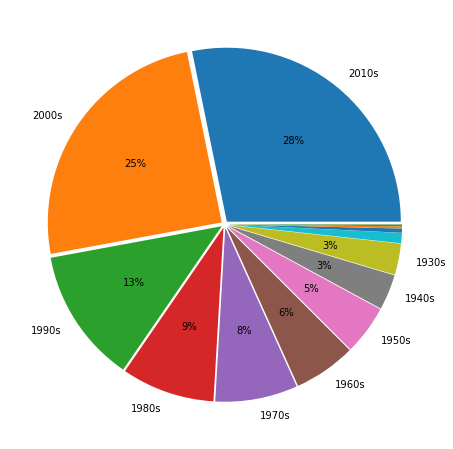

In [10]:
def pie(series,filename):
    counts=series.value_counts()
    counts=counts/counts.sum()
    labels=['' if num<0.01 else str(year) for (year,num) in counts.items()]
    f, ax = plt.subplots(figsize=(8, 8))
    explode = [0.02 if counts.iloc[i] < 100 else 0.001 for i in range(counts.size)]
    plt.pie(counts,labels=labels,autopct=lambda x:'{:1.0f}%'.format(x) if x > 1 else '',explode=explode)
    plt.show()

def decade_pie(df,filename):
    pie(df.release_date.dropna().apply(lambda x:str(int(x[:4])//10*10)+'s'),filename)
    
decade_pie(df,filename="pie_decade.png")

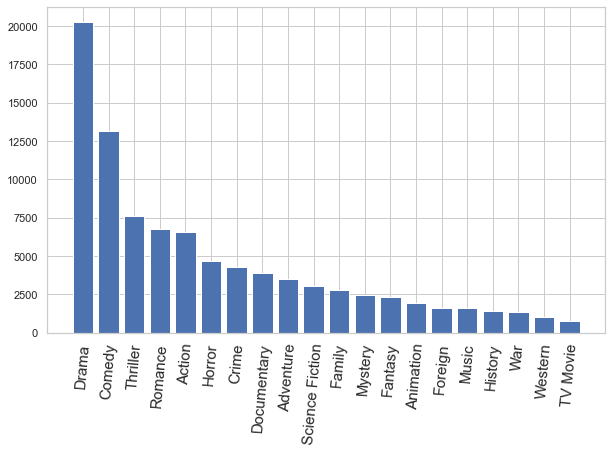

In [11]:
def multi_bar(series,filename):    
    sns.set(style="whitegrid")
    count=multi_count(series,"name")
    count=sorted(count.items(),key=lambda x:x[1],reverse=True)
    count=dict(count[:30])
    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation=85, fontsize=15)
    plt.bar(count.keys(),count.values(),align="center")
    plt.show()

multi_bar(df.genres,filename="bar_genres.png")

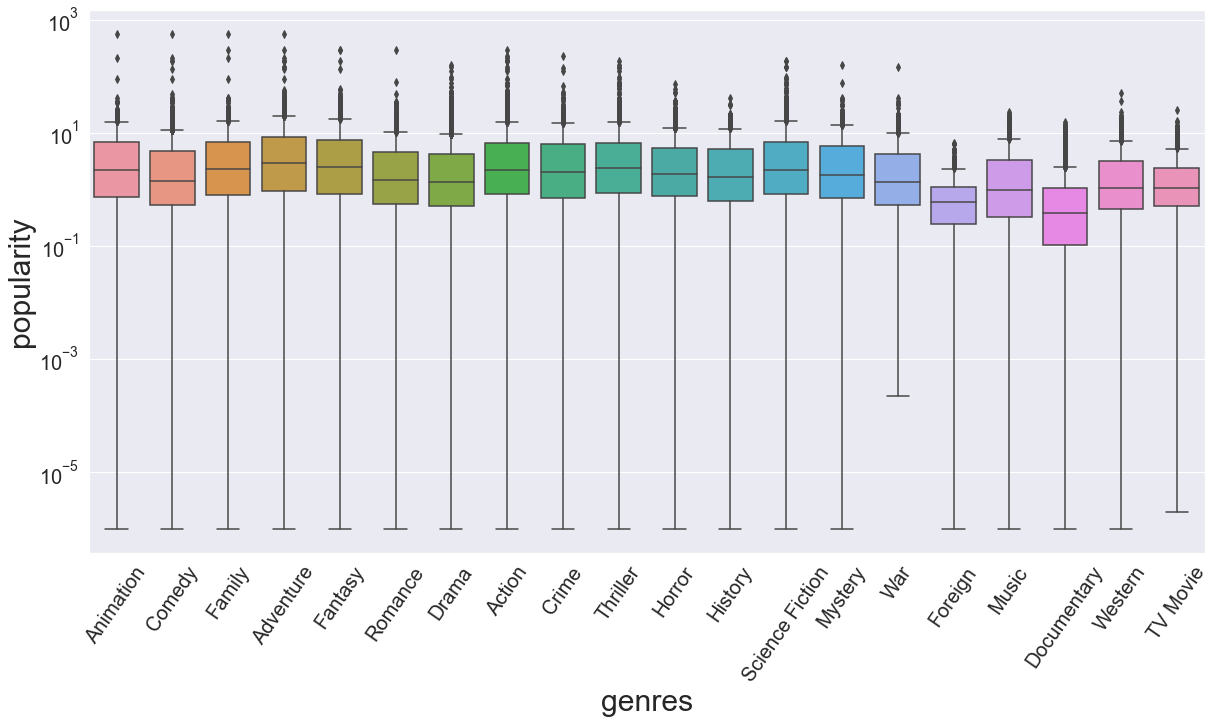

In [12]:
def plotby_box(df,x,y,filename,yscale="linear"):
    sns.set(style="darkgrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    sns.boxplot(data=expand_multi_feature(df,x,"name"),x=x,y=y)
    plt.yscale(yscale)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    plt.show()
    
plotby_box(df,"genres","popularity",yscale="log",filename="genres_popularity.png")

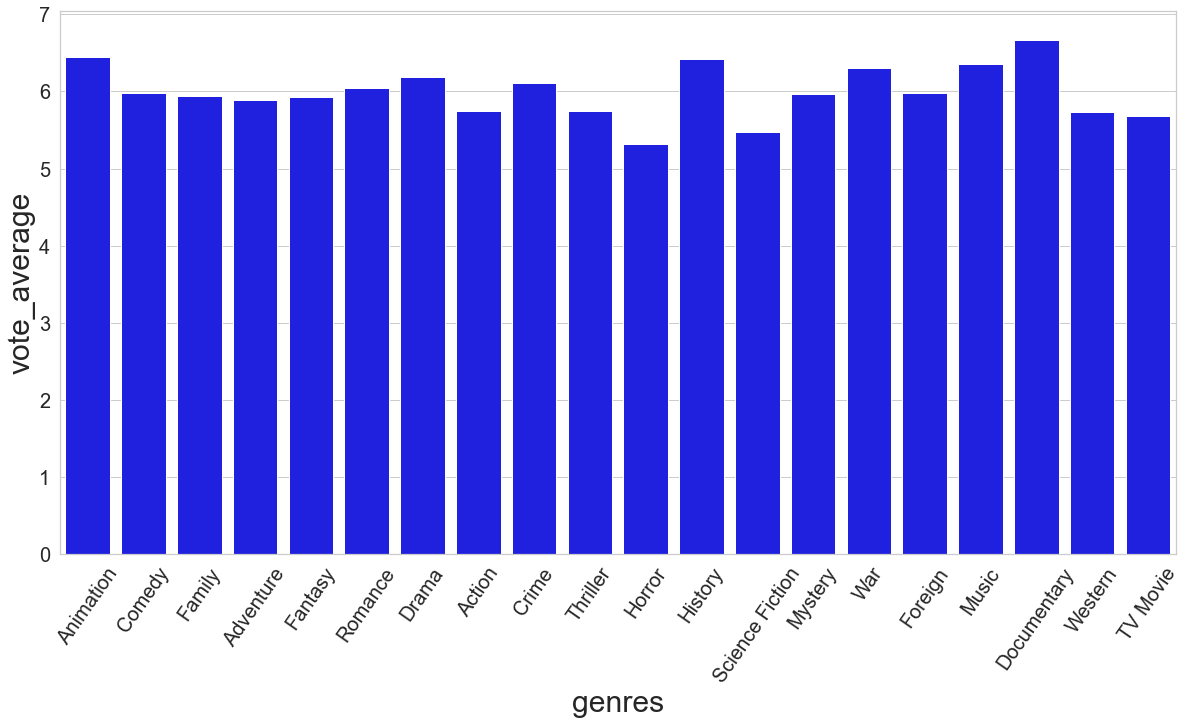

In [13]:
def plotby_bar(df,x,y,filename):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    sns.barplot(data=expand_multi_feature(df,x,"name"),x=x,y=y, errwidth=0, color='blue')
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    plt.show()
    
plotby_bar(df,"genres","vote_average",filename="genres_vote.png")

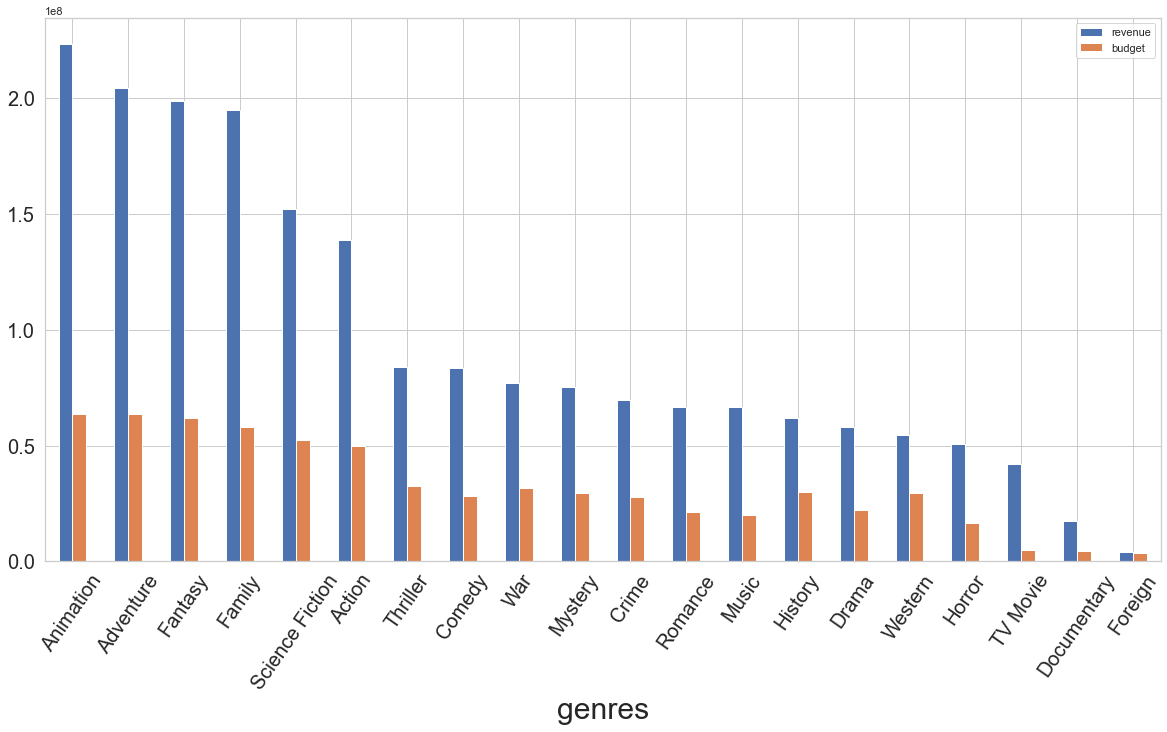

In [14]:
def plotby_2bar(df,x,y,filename):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    multi_groupby(df.dropna(subset=y),x,"name")[y].mean().sort_values(y,ascending=False).plot(kind="bar",ax=ax)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.show()

plotby_2bar(df,"genres",["revenue","budget"],filename="genres_budget_revenue.png")

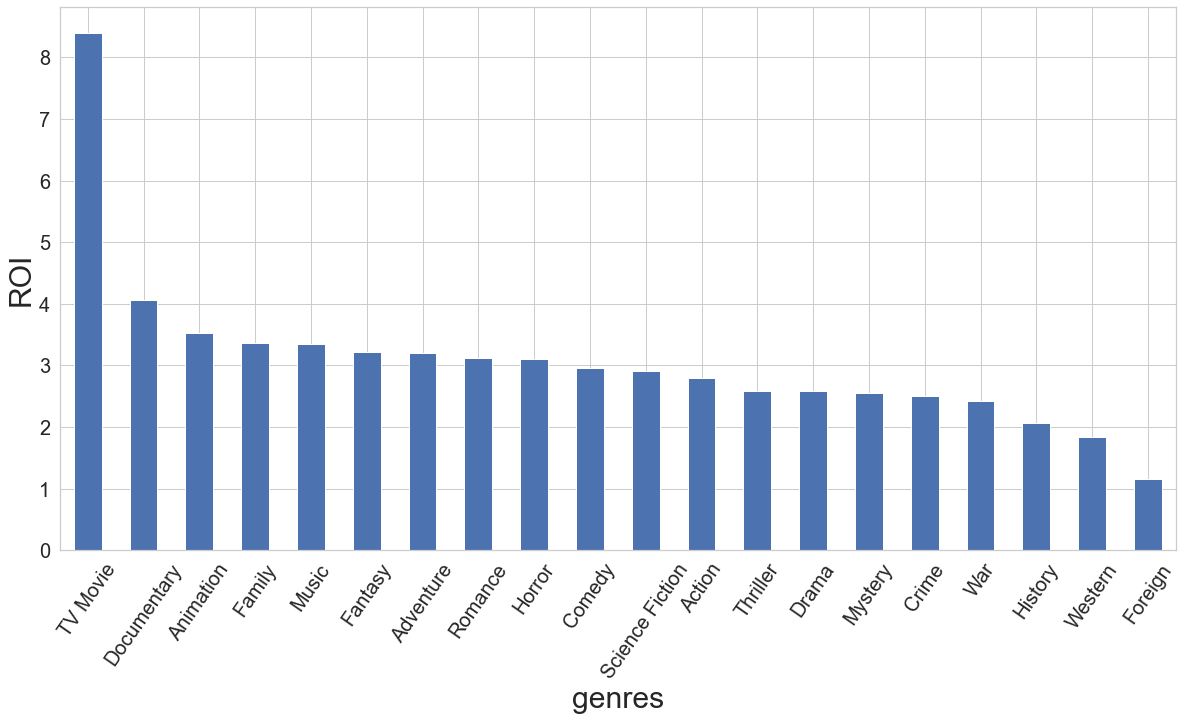

In [15]:
def plotby_portion(df,x,y,filename):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    group=multi_groupby(df.dropna(subset=y),x,"name")
    (group[y[0]].mean()/group[y[1]].mean()).sort_values(ascending=False).plot(kind="bar")
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel("ROI",fontsize=30)
    plt.show()
    
plotby_portion(df,"genres",["revenue","budget"],filename="genres_ROI.png")

In [16]:
df['release_year'] = pd.to_datetime(df.release_date).dt.year

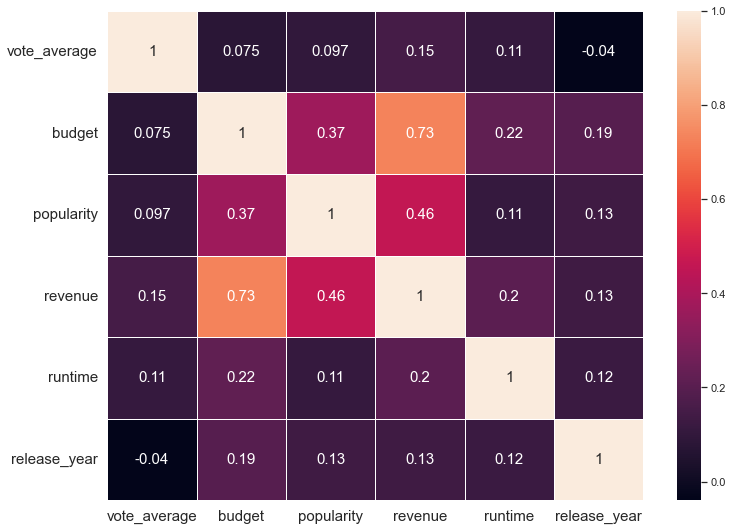

In [17]:
def plot_corr(df,filename):
    plt.subplots(figsize=(12, 9))
    sns.heatmap(df.corr(),annot=True,linewidths=.5,annot_kws={"fontsize":15})
    plt.yticks(rotation=0,fontsize=15)
    plt.xticks(rotation=0,fontsize=15)
    plt.show()

plot_corr(df[["vote_average", "budget","popularity","revenue","runtime","release_year"]],filename="corr.png")

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings('ignore')

In [19]:
data = df[['budget', 'runtime', 'vote_average']]
data.dropna(inplace = True)

In [20]:
X = data[['budget', 'runtime']]
y = data['vote_average']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)

In [22]:
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression()

In [25]:
mean_absolute_error(y_test, linear.predict(X_test))

0.7905391888025951

In [26]:
mean_squared_error(y_test, linear.predict(X_test))

1.0446116219415977

In [27]:
mean_absolute_error(y_test, linear.predict(X_test))/ np.mean(y_test)

0.12974758977804224

In [28]:
np.mean(y_test)

6.092900763358778

In [29]:
xgb_clf = XGBRegressor(n_estimators= 500, max_depth= 5, subsample = 0.9, colsample_bytree = 0.8) 
xgb_clf = xgb_clf.fit(X_train, y_train)

In [30]:
mean_absolute_error(y_test, xgb_clf.predict(X_test))

0.7994096135820141

In [31]:
mean_squared_error(y_test, xgb_clf.predict(X_test))

1.1231785426523562

In [32]:
clf_dt=DecisionTreeRegressor(max_depth= 25,  min_samples_leaf = 4, min_samples_split = 16)
clf_dt.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=25, min_samples_leaf=4, min_samples_split=16)

In [33]:
mean_absolute_error(y_test, clf_dt.predict(X_test))

0.8082288680361199

In [34]:
mean_squared_error(y_test, clf_dt.predict(X_test))

1.1303497541563818